In [1]:
%reset -f
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
pylab.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Backtester.SignalLibrary import Signals as sl

In [3]:
crisis_periods = {
    
    'Black Monday': ['1987/08/25', '1987/10/19'], 
    'Gulf War': ['1990/07/16', '1990/10/11'], 
    'Russian Debt Crisis': ['1998/07/17', '1998/08/31'],
    'Dot Com': ['2000/09/01', '2000/11/30'],
    '9/11': ['2001/09/01', '2001/09/30'],
    'Subprime': ['2007/10/09', '2008/03/09'], 
    'Lehman': ['2008/05/19', '2009/03/09'],
    'Flash Crash': ['2010/05/03', '2010/06/30'],
    'Euro Crisis': ['2011/08/01', '2011/08/08'],
    'Volpocalypse': ['2018/02/01', '2018/02/08'],
    'Equity Sell Off': ['2018/09/20', '2018/12/24'],
    'COVID-19': ['2020/02/19', '2020/03/23'],

}

In [19]:
EQ_df = sl.signal_get_data(['SP1 A:03_0_R Index', 'PT1 A:03_0_R Index','NK1 A:03_0_R Index',
                            'Z 1 A:03_0_R Index', 'VG1 A:03_0_R Index', 'XP1 A:03_0_R Index',
                            'MES1 A:03_0_R Index'],
                           'PX_LAST',
                           '19800101').pull()

def get_mabo_strat(df, lkbks=[21, 63, 260]):
    strat = pd.concat({lkbk: df.subtract(df.shift(1).rolling(lkbk,
                                                             min_periods=lkbk).mean()) for lkbk in lkbks}, axis=1)
    return strat.apply(np.sign).apply(lambda x: np.maximum(x, 0)).mean(axis=1).apply(np.sign)
w_eq = np.array([0.43, 0.03, 0.10, 0.07, 0.19, 0.03, 0.15])
EQ_df.dropna(how='all',inplace=True)
strat_df = EQ_df.apply(get_mabo_strat).dropna(how='all')
mabo_strat = strat_df.shift(1).multiply(EQ_df.pct_change()).dropna(how='all')

vol_tgt = 0.15
strat_anal = pd.DataFrame()
strat_anal['long_only'] = EQ_df.pct_change().multiply(w_eq).sum(axis=1)
strat_anal['long_and_out'] = mabo_strat.multiply(w_eq).sum(axis=1)
strat_anal['long_only'] = strat_anal['long_only'].multiply((vol_tgt/16)/strat_anal['long_only'].\
                                                           rolling(252).std().shift(1))
strat_anal['long_and_out'] = strat_anal['long_and_out'].multiply((vol_tgt/16)/strat_anal['long_and_out'].\
                                                                 rolling(252).std().shift(1))


In [295]:
stats = pd.concat([strat_anal['1985/01':].mean()*252,
           strat_anal['1985/01':].std()*16,
           strat_anal['1985/01':].mean()*16/strat_anal['1985/01':].std()], axis=1)

stats.columns =['Excess Return', 'Volatility', 'Sharpe']
stats.T

,long_only,long_and_out
Excess Return,0.075132,0.085728
Volatility,0.162924,0.156228
Sharpe,0.468470,0.557442


In [47]:
import statsmodels.api as sm
reg_df = strat_anal['1985/01':].apply(lambda x: 1+x).cumprod().resample('M').last().pct_change().copy()
model= sm.OLS(reg_df['long_and_out'],
              sm.add_constant(reg_df['long_only']),
              missing='drop').fit()

In [74]:
reg_df['outperformance'] = model.resid
reg_df['long_only_2'] = reg_df['long_only']**2

In [76]:
model= sm.OLS(reg_df['outperformance'],
              sm.add_constant(reg_df[['long_only','long_only_2']]),
              missing='drop').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         outperformance   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     62.80
Date:                Mon, 09 Aug 2021   Prob (F-statistic):           1.08e-24
Time:                        20:37:04   Log-Likelihood:                 1100.6
No. Observations:                 439   AIC:                            -2195.
Df Residuals:                     436   BIC:                            -2183.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0062      0.001     -5.637      0.000      -0.008      -0.004
long_only       0.0706      0.022      3.254      0.001       0.028       0.113
long_only_2     2.7350      0.244     11.207      0.000       2.255       3.215
==============================================================================
Omnibus:                       53.461   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.161
Skew:                          -0.460   Prob(JB):                     6.29e-46
Kurtosis:                       6.245   Cond. No.                         258.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Beta Adjusted Performance vs Long Only')

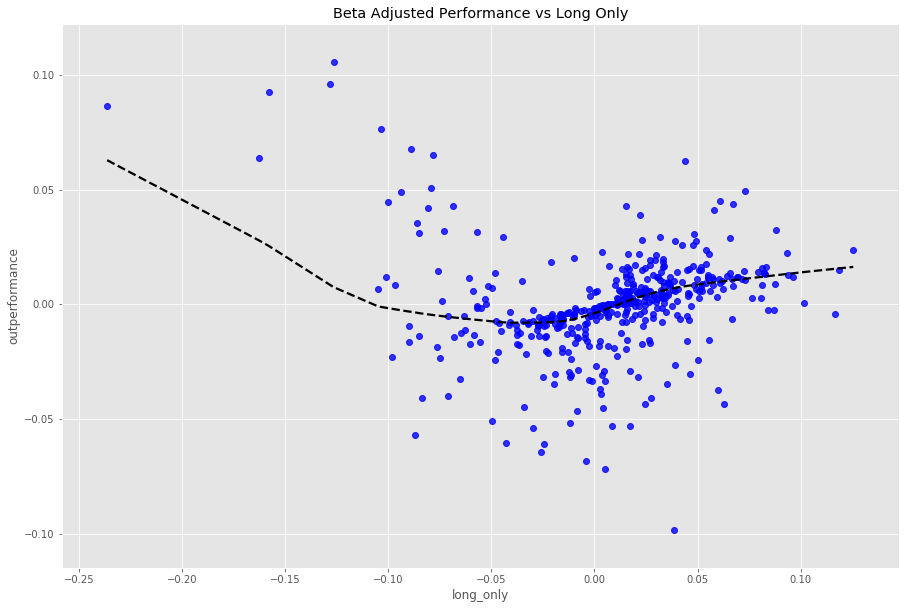

In [77]:
sns.regplot( 'long_only','outperformance', reg_df, color='blue',
            line_kws= {'color':'black','linestyle':'--'},
            lowess=True)
plt.title('Beta Adjusted Performance vs Long Only')

Text(0.5, 1.0, 'TFM Equity Factor - Long and Out vs Long Only  @ 15% Volatility')

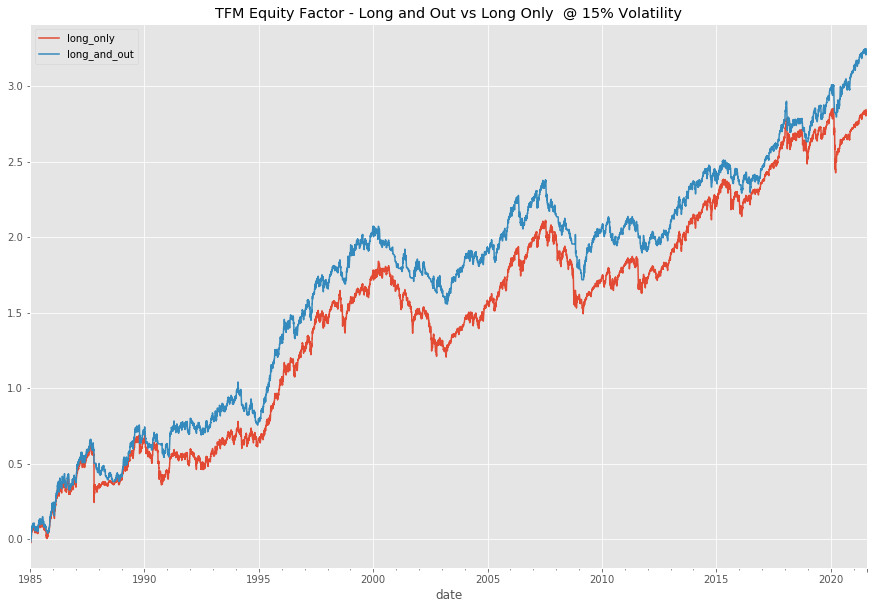

In [42]:
strat_anal['1985/01':].cumsum().plot()
plt.title('TFM Equity Factor - Long and Out vs Long Only  @ 15% Volatility')

Text(0.5, 1, 'Performance During Crisis Periods %')

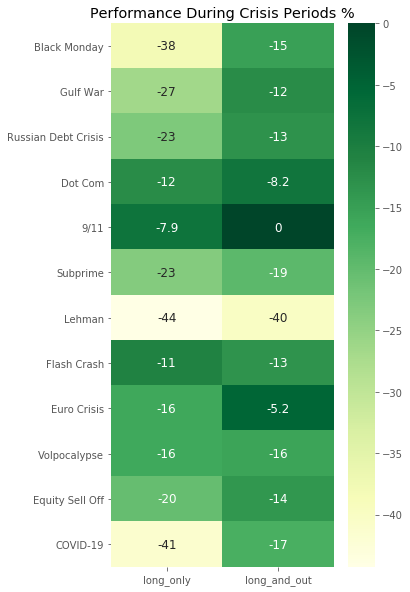

In [24]:
perf_df = strat_anal['1985/01':]
crisis_rets = {}
for period in crisis_periods:
    peak = crisis_periods[period][0]
    trough = crisis_periods[period][1]
    crisis_rets[period] = perf_df.loc[peak:trough].cumsum().iloc[-1]

crisis_rets_df = pd.concat(crisis_rets, axis=1).apply(np.round, args=(4,))*100

plt.subplots(figsize=(5, 10))
sns.heatmap(crisis_rets_df.T, annot=True, cmap='YlGn', annot_kws={'size':12})
plt.title('Performance During Crisis Periods %')

In [227]:
sector_tickers = ['S5ENRS Index', 'S5INFT Index', 'S5FINL Index',
                  'S5HLTH Index', 'S5UTIL Index', 'S5COND Index',
                  'S5INDU Index', 'S5CONS Index', 'S5TELS Index',
                  'S5MATR Index', 'S5RLST Index', 'SPXT Index']
ids = ['Energy', 'IT', 'Financials', 'Health Care', 
       'Utilities', 'Cons. Disc', 'Industrials', 
       'Consumer Staples', 'Comms', 'Materials', 
       'Real Estate', 'SPX']
sector_df = sl.signal_get_data(sector_tickers,
                            'TOT_RETURN_INDEX_GROSS_DVDS',
                           '19800101').pull()

sector_df.columns = ids
ret_sectors = sector_df['2020/02/19':'2020/03/31'].pct_change()

In [160]:
covid_stats = pd.concat([ret_sectors.std()*sqrt(252), 
                         ((1+ret_sectors.dropna()).cumprod().iloc[-1]**(1/len(ret_sectors-1))-1)], axis=1)
covid_stats.columns = ['Ex Post. Volatility', 'Compounded Return']
covid_stats['Sector Weight % as of 2020/02/19'] = [1.58, 4.76, 16.56, 
                                                   2.62, 29.05, 3.73, 6.34, 
                                                   9.05, 3.32, 1.83, 21.03, np.nan]
covid_stats
covid_stats.sort_values(by='Ex Post. Volatility')

,Ex Post. Volatility,Compounded Return,Sector Weight % as of 2020/02/19
Consumer Staples,0.708233,-0.005374,9.05
Comms,0.718089,-0.008259,3.32
Health Care,0.726452,-0.005196,2.62
Cons. Disc,0.741596,-0.009168,3.73
SPX,0.824477,-0.008883,NaN
Materials,0.842439,-0.009551,1.83
Industrials,0.890203,-0.011511,6.34
Real Estate,0.924045,-0.009201,21.03
IT,0.931358,-0.008003,4.76
Utilities,0.935056,-0.007554,29.05


In [282]:
lv_data = sl.signal_get_data(['SP5LVIT Index',
                              'SPUSTTTR Index',
                              'SPXT Index'],
                             'PX_LAST', '19800101').pull()
lv_data.columns = ['low_vol', 'TY10', 'SPX']
lv_data = lv_data.pct_change()
lv_mdl = sm.OLS(lv_data['low_vol'], 
                sm.add_constant(lv_data['SPX']), 
                missing='drop').fit()
lv_data['lv_residuals'] = lv_mdl.resid.copy()
sm.OLS(lv_data['lv_residuals'], 
                sm.add_constant(lv_data['TY10']), 
                missing='drop').fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           lv_residuals   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     196.0
Date:                Tue, 10 Aug 2021   Prob (F-statistic):           4.66e-44
Time:                        02:41:47   Log-Likelihood:                 35863.
No. Observations:                8765   AIC:                        -7.172e+04
Df Residuals:                    8763   BIC:                        -7.171e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.251e-05   4.33e-05     -0.982      0.326      -0.000    4.24e-05
TY10           0.1656      0.012     14.000      0.000       0.142       0.189
==============================================================================
Omnibus:                     1890.884   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            68384.881
Skew:                          -0.242   Prob(JB):                         0.00
Kurtosis:                      16.675   Cond. No.                         274.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Correlation to Treasury')

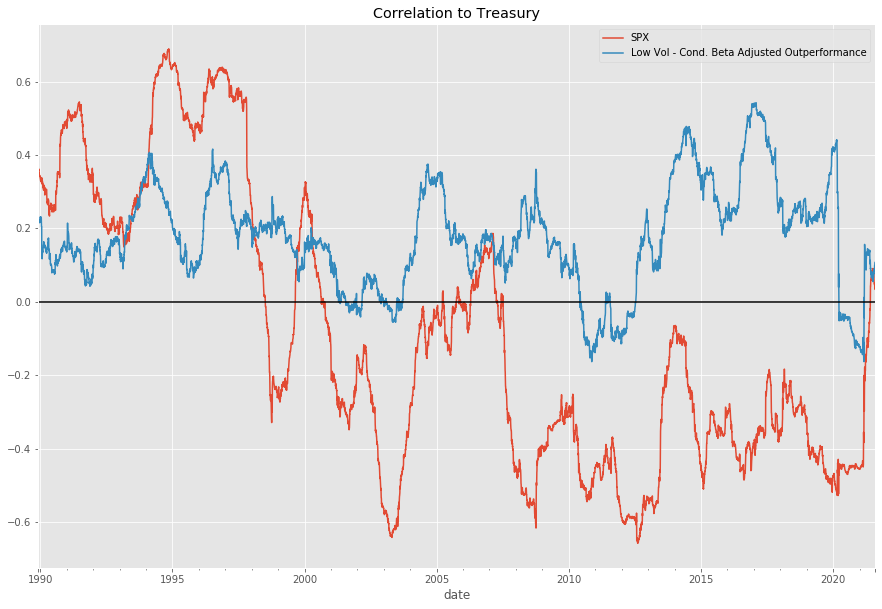

In [293]:
lv_data['cov_sp_lv'] = lv_data[['SPX','low_vol']].rolling(252).\
                        cov(lv_data['SPX'])['low_vol']
lv_data['var_spx'] = lv_data['SPX'].rolling(252).var()
lv_data['Low Vol - Cond. Beta Adjusted Outperformance'] = lv_data['low_vol'] - (lv_data['cov_sp_lv'].divide(lv_data['var_spx'])).\
                                        shift(1).multiply(lv_data['SPX'])

lv_data.rolling(252).corr(lv_data['TY10'])[['SPX','Low Vol - Cond. Beta Adjusted Outperformance']].dropna().plot()
plt.axhline(0, color='black')
plt.title('Correlation to Treasury')